# Diesel Cycle Example

## Imports

In [1]:
from thermostate import State, Q_, units
from thermostate.plotting import IdealGas
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import arange

---

## Definitions

In [2]:
substance = 'air'
T_1 = Q_(25.0, 'degC')
p_1 = Q_(95.0, 'kPa')
V_1 = Q_(3.0, 'L')
r = Q_(18.0, 'dimensionless')
r_c = Q_(3.0, 'dimensionless')
rpm = Q_(1700.0, 'rpm')
n_C = Q_(4, 'dimensionless')
units.define('cycle = 2*revolution')  # Define a four-stroke cycle
r_c_low = Q_(1.1, 'dimensionless')
r_c_high = Q_(4.5, 'dimensionless')

---

## Problem Statement

A four-cylinder Diesel engine has a BDC volume of 3.0 L per cylinder. The engine operates on the air-standard Diesel cycle with a compression ratio of 18.0  and a cutoff ratio of 3.0 . Air is at 25.0 celsius and 95.0 kPa at the beginning of the compression process. Determine

1. the amount of power delivered by the engine, in kW, at 1700.0 rpm
2. the thermal efficiency
3. plot the power output as a function of the cutoff ratio, with values for $r_c$ from 1.1  to 4.5 , holding all other given values constant
4. plot the thermal efficiency as a function of the cutoff ratio, with values for $r_c$ from 1.1  to 4.5 , holding all other given values constant

---

## Solution

### 1. the power delivered

The power output can be found by taking the product of the net work per cylinder, the number of cylinders, and the net work per revolution

$$\dot{W}_{net} = n_C \frac{N}{2} W_{net}$$

First, we need to fix the four states. State 1 uses $p$ and $T$, state 2 uses $s$ and $v$, state 3 uses $p$ and $v$, and state 4 uses $v$ and $s$. We need to calculate the mass of air in one cylinder using the ideal gas law

$$m = \frac{pV}{RT}$$

where $R=\overline{R}/MW$ is the gas-specific constant.

In [3]:
MW_air = Q_(28.97, 'kg/kmol')
R = units.molar_gas_constant/MW_air
m = (p_1*V_1/(R*T_1)).to('mg')

v_1 = (V_1/m).to('m**3/kg')
st_1 = State(substance, p=p_1, T=T_1)
s_1 = st_1.s.to('kJ/(kg*K)')
u_1 = st_1.u.to('kJ/kg')

v_2 = v_1/r
s_2 = s_1
st_2 = State(substance, v=v_2, s=s_2)
T_2 = st_2.T
p_2 = st_2.p.to('kPa')
u_2 = st_2.u.to('kJ/kg')

v_3 = r_c*v_2
p_3 = p_2
st_3 = State(substance, p=p_3, v=v_3)
T_3 = st_3.T
s_3 = st_3.s.to('kJ/(kg*K)')
u_3 = st_3.u.to('kJ/kg')

s_4 = s_3
v_4 = st_1.v
st_4 = State(substance, v=v_4, s=s_4)
T_4 = st_4.T
p_4 = st_4.p.to('kPa')
u_4 = st_4.u.to('kJ/kg')

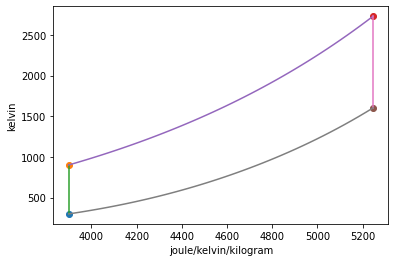

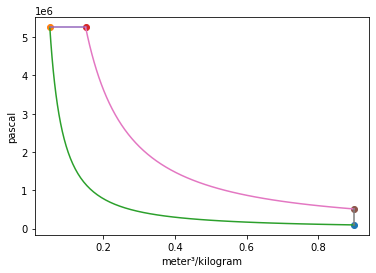

In [10]:
Diesel = IdealGas(substance, ('s', 'T'), ('v', 'p'))

Diesel.add_process(st_1, st_2, 'isentropic')
Diesel.add_process(st_2, st_3, 'isobaric')
Diesel.add_process(st_3, st_4, 'isentropic')
Diesel.add_process(st_4, st_1, 'isochoric')

The mass of air in one cylinder is $m =$ 3330.61 mg. Summarizing the states:

| State |             T             |             p             |             u             |             v             |             s             |
|-------|---------------------------|---------------------------|---------------------------|---------------------------|---------------------------|
|     1 | 298.15 K | 95.00 kPa | 338.89 kJ/kg | 0.90 m<sup>3</sup>/kg | 3.90 kJ/(K kg) |
|     2 | 900.45 K | 5256.76 kPa | 799.36 kJ/kg | 0.05 m<sup>3</sup>/kg | 3.90 kJ/(K kg) |
|     3 | 2730.75 K | 5256.76 kPa | 2522.03 kJ/kg | 0.15 m<sup>3</sup>/kg | 5.25 kJ/(K kg) |
|     4 | 1602.36 K | 511.21 kPa | 1426.75 kJ/kg | 0.90 m<sup>3</sup>/kg | 5.25 kJ/(K kg) |


In [17]:
W_12 = (m*(u_1 - u_2)).to('kJ')
W_23 = (m*p_2*(v_3 - v_2)).to('kJ')
W_34 = (m*(u_3 - u_4)).to('kJ')

W_net = W_12 + W_23 + W_34

Q_23 = (m*(u_3 - u_2) + W_23).to('kJ')
Q_41 = (m*(u_1 - u_4)).to('kJ')

Summarizing the energy transfers,

|     Process       |            Work            |       Heat Transfer        |
|-------------------|----------------------------|----------------------------|
| 1 $\rightarrow$ 2 | -1.53 kJ | 0.0 kJ                     |
| 2 $\rightarrow$ 3 | 1.75 kJ | 7.49 kJ |
| 3 $\rightarrow$ 4 | 3.65 kJ | 0.0 kJ                     |
| 4 $\rightarrow$ 1 | 0.0 kJ                     | -3.62 kJ |

and the net work output per cylinder per cycle is $W_{net} =$ 3.87 kJ. Then, calculating the power output

In [18]:
Wdot_net = (n_C*rpm*W_net/units.cycle).to('kW')

<div class="alert alert-success">

**Answer:** The net power output is $\dot{W}_{net} =$ 219.10 kW

</div>

### 2. the thermal efficiency

In [19]:
eta = W_net/Q_23

<div class="alert alert-success">

**Answer:** The thermal efficiency is $\eta =$ 0.52  = 51.62% 

</div>

### 3. plot the net power output as a function of $r_c$

For this part (and the next one), only states 3 and 4 are changed by changing the cutoff ratio. Therefore, we only re-compute those states, and the associated work and heat transfer values, in the following loop.

In [20]:
eta_l = []
Wdot_net_l = []
r_c_l = arange(r_c_low.magnitude, r_c_high.magnitude+0.1, 0.1)
for r_c in r_c_l:
    v_3 = r_c*v_2
    p_3 = p_2
    st_3 = State(substance, p=p_3, v=v_3)
    s_3 = st_3.s.to('kJ/(kg*K)')
    u_3 = st_3.u.to('kJ/kg')

    s_4 = s_3
    v_4 = v_1
    st_4 = State(substance, v=v_4, s=s_4)
    u_4 = st_4.u.to('kJ/kg')

    W_23 = (m*p_2*(v_3 - v_2)).to('kJ')
    W_34 = (m*(u_3 - u_4)).to('kJ')

    W_net = W_12 + W_23 + W_34
    Wdot_net = (n_C*rpm*W_net/units.cycle).to('kW')
    Wdot_net_l.append(Wdot_net.magnitude)

    Q_23 = (m*(u_3 - u_2) + W_23).to('kJ')
    eta = W_net/Q_23
    eta_l.append(eta.magnitude)

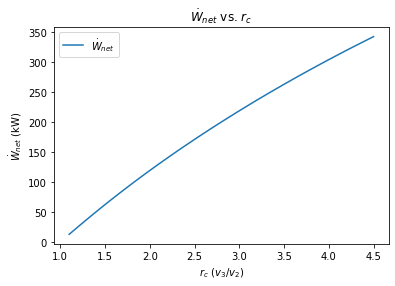

In [21]:
plt.figure()
plt.plot(r_c_l, Wdot_net_l, label='$\dot{W}_{net}$')
plt.legend(loc='best')
plt.title('$\dot{W}_{net}$ vs. $r_c$')
plt.xlabel('$r_c$ ($v_3/v_2$)')
plt.ylabel('$\dot{W}_{net}$ (kW)');

### 4. plot $\eta$ vs. $r_c$

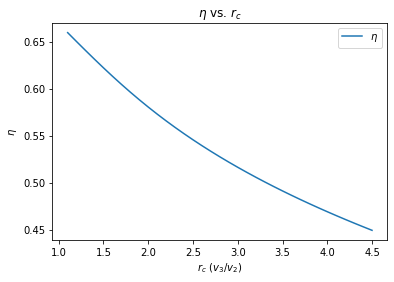

In [22]:
plt.figure()
plt.plot(r_c_l, eta_l, label='$\eta$')
plt.legend(loc='best')
plt.title('$\eta$ vs. $r_c$')
plt.xlabel('$r_c$ ($v_3/v_2$)')
plt.ylabel('$\eta$');

From these graphs, we note that as the cutoff ratio increases, the power delivered increases but the thermal efficiency decreases.